### МАИ
### ФИО студента: Меркулов Лев Владимирович
### группа: Т120-101М-20
### ФИО руководителя: Джумурат Александр
### дата: 23.03.2021
### ДЗ № 3, Аналитика
### Москва, 2021 г.

# Домашняя работа "Аналитика"

# Часть I: исходные данные

### Задача 1: Конверсия в просмотр

Напишите запрос, который сравнит конверсию в просмотр между двумя странами: Россия и Украина

* сгруппируйте данные по полям страна + день
* исключите просмотры, которые были совершены в субботу и воскресенье

In [5]:
import os
import pandas as pd
from sqlalchemy import create_engine


postgres_host = '127.0.0.1' #'178.154.200.231' #os.environ['APP_POSTGRES_HOST']
database = 'postgres'
port = '5433'
user = 'mai'
password = '1930'

engine = create_engine(
    f'postgresql://{user}:{password}@{postgres_host}:{port}/{database}'
)

# ----- ВАШ КОД ТУТ  -------


sql_str = """
SELECT
    SUM(content_watch)::float / SUM(content_impression)::float as conversion,
    dow,
    country
FROM (
    SELECT
        user_id_for_mai,
        content_id,
        to_char(to_timestamp(rocket_datetime), 'ID') as dow,
        country,
        MAX(CASE WHEN name in ('page_impression', 'click') THEN 1 ELSE 0 END) as content_impression,
        MAX(CASE WHEN name='content_watch' THEN 1 ELSE 0 END) as content_watch
    FROM 
        movie.events 
    WHERE
        content_id > 0 AND country IN ('Россия','Украина')
    GROUP BY 
        user_id_for_mai, content_id, dow, country
    ORDER BY 
        dow
) as tmp
WHERE
    dow NOT IN ('6', '7') AND content_impression > 0
GROUP BY
    dow, country
"""

# ----- ВАШ КОД ТУТ  -------

conversion_df_UR = pd.read_sql(sql_str, engine)
conversion_df_UR

,conversion,dow,country
0,0.383954,1,Россия
1,0.366715,1,Украина
2,0.378882,2,Россия
3,0.373813,2,Украина
4,0.373153,3,Россия
5,0.400766,3,Украина
6,0.386308,4,Россия
7,0.362606,4,Украина
8,0.376669,5,Россия
9,0.437662,5,Украина


Визуализация: постройте графики изменения конверсии по дням

<AxesSubplot:xlabel='dow'>

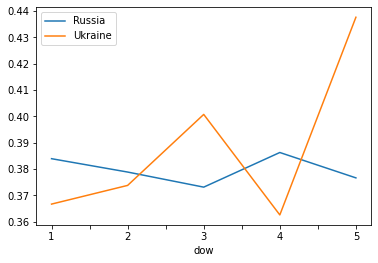

In [6]:
# ----- ВАШ КОД ТУТ  -------
%matplotlib inline

df1 = conversion_df_UR[conversion_df_UR['country']=='Россия']
df2 = conversion_df_UR[conversion_df_UR['country']=='Украина']


ax = df1.plot(x='dow', y='conversion', label='Russia')
df2.plot(x='dow', y='conversion', ax=ax, label='Ukraine')
# --------------------------

Визуализация: постройте гистограмму распределения конверсии

<AxesSubplot:ylabel='Frequency'>

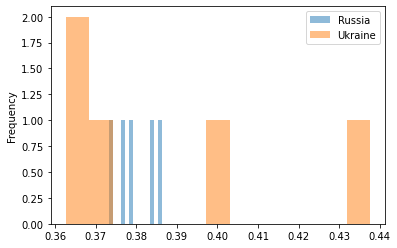

In [62]:
conversion_df_UR[
    conversion_df_UR['country']=='Россия'
]['conversion'].plot(kind='hist', alpha=0.5, bins=13, label='Russia', legend=True)

conversion_df_UR[
    conversion_df_UR['country']=='Украина'
]['conversion'].plot(kind='hist', alpha=0.5, bins=13, label='Ukraine', legend=True)

### **Задача** с лекции: конверсия с Windows и Xbox

Например, рассмотрим продуктовую метрику "конверсия из показа карточки контента в просмотр":  
* пользователь заходит на главную страницу ivi
* рекомендательная система показывает постеры нескольких карточек контента
* если рекомендательная система угадалы вкусы пользователя - начинается просмотр контента. Если выдача рекомендаций пользователю не подходит - событие "просмотр контента" не возникает

![main_page_ivi](img/main_page_ivi.png)

Вычислим эту метрику с помощью SQL на основании данных событийной аналитики
* берём только события с платформ `xboxOne` и `Windows 10`
* тип события `page_impression` (показ контента) и `click` (клик по постеру)
* валидация событий: просмотры, у которых отсутствует `impression` из выборки исключаем
* считаем конверсию по датам в разбивке по платформам

Цель исследования - понять, есть ли отличия в конверсии между просмотрами на платформах `xboxOne` и `Windows 10`

In [69]:
import os
import pandas as pd
from sqlalchemy import create_engine


postgres_host = '127.0.0.1' #os.environ['APP_POSTGRES_HOST'] # '40.89.151.14' #os.environ['APP_POSTGRES_HOST']
database = 'postgres'
port = '5433' #os.environ['APP_POSTGRES_PORT'] # '5433'
user = 'mai'
password = '1930'

engine = create_engine(
    f'postgresql://{user}:{password}@{postgres_host}:{port}/{database}'
)

sql_str = """
SELECT
    date,
    subsite_title,
    SUM(content_watch)::float / SUM(content_impression)::float as conversion
FROM (
    SELECT
        user_id_for_mai,
        content_id,
        subsite_title,
        to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD') as date,
        MAX(CASE WHEN name in ('page_impression', 'click') THEN 1 ELSE 0 END) as content_impression,
        MAX(CASE WHEN name='content_watch' THEN 1 ELSE 0 END) as content_watch
    FROM movie.events
    WHERE
        content_id > 0
        AND subsite_title in ('xboxOne', 'Windows 10')
    GROUP BY user_id_for_mai, content_id, date, subsite_title
) as content_watches
WHERE
    content_impression > 0
GROUP BY date, subsite_title
ORDER BY date, subsite_title
"""

conversion_df_WX = pd.read_sql(sql_str, engine)

conversion_df_WX.head()

,date,subsite_title,conversion
0,2019-06-01,Windows 10,0.197802
1,2019-06-01,xboxOne,0.200704
2,2019-06-02,Windows 10,0.287532
3,2019-06-02,xboxOne,0.270677
4,2019-06-03,Windows 10,0.439331


<AxesSubplot:ylabel='Frequency'>

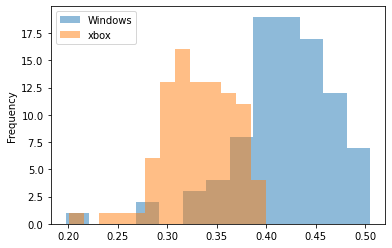

In [72]:
conversion_df_WX[
    conversion_df_WX['subsite_title']=='Windows 10'
]['conversion'].plot(kind='hist', alpha=0.5, bins=13, label='Windows', legend=True)

conversion_df_WX[
    conversion_df_WX['subsite_title']=='xboxOne'
]['conversion'].plot(kind='hist', alpha=0.5, bins=13, label='xbox', legend=True)

### Задача 2:  Retention

Посчитайте возвращаемость (недельную) пользователей на сервис на день X

* найдите множество $y1$ пользователей, которые заходили в период от $X-14$ до $X-7$
* найдите множество $y2$, которые заходили в период от $X-6$ до $X$
* найдите пересечение множеств $y1$ и $y2$ и разделите его на объединение этих множеств - это и будет наша метрика retention

Пример вычисления retention на конкретную дату доступен на youtube: https://youtu.be/Nds_9ZTihIY

```mysql
SELECT
    '2019-08-01' retention_date,
    COUNT(user_id_for_mai) previous_week_user_count,
    SUM(current_week) current_week_user_count,
    SUM(current_week) / SUM(previous_week)::float retention
FROM (
    SELECT
        user_id_for_mai,
        MAX(
            CASE
                WHEN (date <= '2019-07-25' and date > '2019-07-18') THEN 1
                ELSE 0
            END
        ) as previous_week,
        MAX(
            CASE
                WHEN (date <= '2019-08-01' and date > '2019-07-25') THEN 1
                ELSE 0
            END
        ) as current_week
    FROM (
        SELECT
            to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD') as date,
            rocket_datetime,
            user_id_for_mai
        FROM movie.events
    ) as raw_stat
    WHERE
        (date <= '2019-08-01' and date > '2019-07-25')
        OR (date <= '2019-07-25' and date > '2019-07-18')
    GROUP BY user_id_for_mai
) as agg_stat
WHERE
    previous_week = 1;

```

In [23]:
# ----- ВАШ КОД ТУТ  -------
import os
import pandas as pd
from sqlalchemy import create_engine


postgres_host = '127.0.0.1' #'178.154.200.231' #os.environ['APP_POSTGRES_HOST']
database = 'postgres'
port = '5433'
user = 'mai'
password = '1930'

engine = create_engine(
    f'postgresql://{user}:{password}@{postgres_host}:{port}/{database}'
)

sql_str ="""
WITH row_stat as (
SELECT 
    user_id_for_mai,
    EXTRACT (WEEK from date) as week_num,
    subsite_title
FROM(
    SELECT 
        to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD')::DATE as date,
        user_id_for_mai,
        subsite_title
    FROM 
        movie.events
    WHERE 
        subsite_title in ('xboxOne', 'Windows 10')
    ORDER BY 
        date ASC
    ) raw_stat
GROUP BY week_num, user_id_for_mai, subsite_title
ORDER BY week_num ASC
)
,
agg_stat as (
SELECT
    week_num::int,
    subsite_title,
    COUNT(user_id_for_mai) as current_week_user_count, 
    SUM(prev_week) as returns
FROM(
    SELECT
        user_id_for_mai,
        week_num,
        subsite_title,
        CASE WHEN 
            LAG(week_num, 1) OVER (PARTITION BY user_id_for_mai ORDER BY week_num ASC) = week_num - 1 
            THEN 1 ELSE 0 END as prev_week 
    FROM 
        row_stat
    GROUP BY 
        user_id_for_mai, week_num, subsite_title
    ORDER BY 
        user_id_for_mai, week_num, subsite_title ASC ) res
GROUP BY week_num, subsite_title
ORDER BY week_num, subsite_title ASC)

SELECT
    week_num,
    subsite_title,
    current_week_user_count, 
    returns,
    LAG(current_week_user_count,2) OVER (ORDER BY week_num ASC) as prev_week_user_count,
    returns/(LAG(current_week_user_count,2) OVER (ORDER BY week_num ASC))::float as retention
FROM agg_stat
"""
# curr_week_user_count - число активных пользователей на текущей неделе
# returns (from previous week) - число пользователей, активных и на текущей, и прошедшей неделе
# retention = returns/prev_week_user_count

retention_df = pd.read_sql(sql_str, engine)

retention_df

,week_num,subsite_title,current_week_user_count,returns,prev_week_user_count,retention
0,22,Windows 10,194,0,NaN,NaN
1,22,xboxOne,149,0,NaN,NaN
2,23,Windows 10,722,61,194.0,0.314433
3,23,xboxOne,464,54,149.0,0.362416
4,24,Windows 10,863,164,722.0,0.227147
5,24,xboxOne,611,164,464.0,0.353448
6,25,Windows 10,943,214,863.0,0.247972
7,25,xboxOne,690,227,611.0,0.371522
8,26,Windows 10,1045,269,943.0,0.285260
9,26,xboxOne,785,300,690.0,0.434783


Постройте гистограмму ретеншна - на какой платформе лучше возвращаемость?

<AxesSubplot:ylabel='Frequency'>

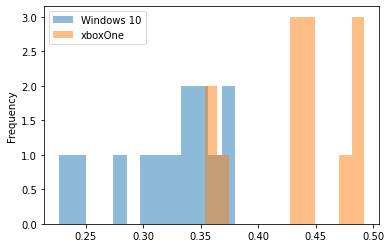

In [77]:
# ----- ВАШ КОД ТУТ  -------

retention_df[
    retention_df['subsite_title']=='Windows 10'
]['retention'].plot(kind='hist', alpha=0.5, bins=13, label='Windows 10', legend=True)

retention_df[
    retention_df['subsite_title']=='xboxOne'
]['retention'].plot(kind='hist', alpha=0.5, bins=13, label='xboxOne', legend=True)

# --------------------------

# Часть II статистические гипотезы

### Задача 3: Предсказательный интервал

пусть результат эксперимента представляет собой нормально распределённую СВ $X\sim N(\mu, \sigma)$. Тогда предсказательный интервал имеет вид
$$
P\left(\mu - Z_{1-\frac{\alpha}{2}}\sigma \le X \le \mu + Z_{1-\frac{\alpha}{2}}\sigma \right) = 1 - \alpha
$$

для тренировки сгенерируйте решите задачу: постройте предсказательный интервал для случайной величины $X\sim N(\mu, \sigma)$:

In [13]:
from scipy.stats import norm

mu = 5
sigma = 0.9
alpha = 0.05
# используйте функцию ppf - Percent point function (обратная к кумулятивной функции (функции вероятности) cdf)

z_05 = mu - norm.ppf(q=1-alpha/2)*sigma
z_95 = mu + norm.ppf(q=1-alpha/2)*sigma

print(f"z_05 = {z_05}, z_95 = {z_95}")

z_05 = 3.2360324139139514, z_95 = 6.763967586086048


Проверка на правильность решения

In [5]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(z_05, 3.5196, places=4)
        self.assertAlmostEqual(z_95, 6.4804, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### Задача 4: Доверительный интервал для математического ожидания гауссовской СВ.

СВ $X\sim N(\mu, \sigma)$, где $\sigma$ известный параметр. По результатам эксперимента получили выборку $X^n = \left( X_1,\ldots,X_n \right)$. Задача - оценить по выборке неизвестный параметр $\mu$.

Чтобы построить доверительный интервал параметра $\mu$ в первую очередь нужно понять, какое распределение имеет параметр, который мы исследуем. В данном случае мы можем воспользоваться результатами ЦПТ:
$$
\overline{X} \sim N\left(\mu, \frac{\sigma^2}{n}\right), \overline{X} = \frac{\sum_{i=1}^{n}X_i}{n}
$$

где $\overline{X}$ - среднее значение элементов выборки. В таком случае доверительный интервал имеет вид
$$
P\left(\overline{X} - z_{\alpha/2}\sqrt{\sigma^2/n} \le  \mu \le \overline{X} + z_{\alpha/2}\sqrt{\sigma^2/n}\right) = 1 - \alpha
$$

Для определения значения квантили можно пользоваться функцией `.ppf` из модуля `scipy.stats`.

In [10]:
from scipy.stats import norm
import numpy as np

mu = 5
sigma = 0.9
X = np.array([13.27543316, 18.60619498, 28.64266817, 45.4103895, 10.08409655,
     44.91948425, 47.23376343, 33.03988962, 31.45570219, 3.089313523])

# используйте функцию ppf для нахождения квантили
alpha = 0.05

n = X.size
left_border = X.mean() - norm.ppf(alpha/2) * np.sqrt(sigma**2 / n)
right_border = X.mean() + norm.ppf(alpha/2) * np.sqrt(sigma**2 / n)

print(f"Оценка математического ожидания по выборке mu = [{left_border}, {right_border}]")

Оценка математического ожидания по выборке mu = [27.0178780082259, 28.13350906637411]


Тесты на решение

In [9]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(left_border, 28.1335, places=4)
        self.assertAlmostEqual(right_border, 27.0179, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Задача 5: конверсии

#### Вычисление конверсии

Посчитайте конверсию по выборке - нужно написать несложный код на python

In [18]:
import pickle

with open('data/pool_sample.pkl', 'rb') as f:
    pool_data = pickle.load(f)

# ---- ВАШ КОД ТУТ ---

conversion = sum(pool_data) / len(pool_data)
print(conversion)

# --------------------

0.77


Тесты

In [19]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(conversion, 0.77, places=2)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


#### Репрезентативный объём выборки

Значение $n$ выборка будет репрезентативной:

$$
n = \left( \frac{Z_{1-\frac{\alpha}{2}}}{\delta}\right)^2pq
$$

Каким образом определить значения $p,q$:
1. из прошлых исследований;
1. еcли дополнительной информации нет, то выбрать $p=q=\frac12$;
1. если известен интервал для $p\in[\alpha, \beta]$, то нужно выбирать значение, максимально близкое к $\frac12$

За кандидата собираются голосовать 30-40%. Сколько нужно опросить респондентов, чтобы оценить долю голосов за кандидата с точность $2\%$.

Написать функцию, которая рассчитывает объём репрезентативной выборки

In [38]:
from math import ceil
from scipy.stats import norm
# подсказка - воспользуйтесь функцией math.ceil()

def representative_sample_size(alpha, delta, p=None):
    """Функция для расчёта объёма репрезентативной выборки
    
    :param alpha: уровень доверия
    :param delta: точность
    :param p (list | int | None): теоретическая вероятность успеха 
    :return: 
    """
    # ---- ВАШ КОД ТУТ ---
    n = (norm.ppf(q=1 - alpha / 2) / delta)**2 * p * (1 - p)
    # --------------------
    return ceil(n)

sample_size = representative_sample_size(alpha=0.05, delta=0.03, p=0.4)

Тесты

In [42]:
import unittest

sample_size = representative_sample_size(alpha=0.05, delta=0.03, p=0.4)

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertEqual(sample_size, 1025)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


#### Моделирование данных

Смоделируйте эксперимент с соц-опросом с помощью распределения Бернулли

* сгенерируйте выборку того размера, который рассчитали
* посчитайте прогнозируемый рейтинг кандидата 

In [43]:
import scipy.stats as sts

# ---- ВАШ КОД ТУТ ---

p = 0.4  # задайте тут правильное значение
print(f'Размер выборки: {sample_size}') # sample_size должна была сохраниться с предыдущей ячейки

bernoulli_rv = sts.bernoulli(p) # эту часть менять не надо

# поищите в документации как генерить выборки
# вызовите правильный метод объекта bernoulli_rv
# используйте параметр random_state = 42
b = bernoulli_rv.rvs(size=sample_size, random_state=42)

estimated_rating = b.mean()
estimated_rating
# --------------------



Размер выборки: 1025


0.3921951219512195

In [44]:
help(sts.bernoulli.rvs)

Help on method rvs in module scipy.stats._distn_infrastructure:

rvs(*args, **kwargs) method of scipy.stats._discrete_distns.bernoulli_gen instance
    Random variates of given type.
    
    Parameters
    ----------
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information).
    loc : array_like, optional
        Location parameter (default=0).
    size : int or tuple of ints, optional
        Defining number of random variates (Default is 1).  Note that `size`
        has to be given as keyword, not as positional argument.
    random_state : {None, int, `~np.random.RandomState`, `~np.random.Generator`}, optional
        This parameter defines the object to use for drawing random
        variates.
        If `random_state` is `None` the `~np.random.RandomState` singleton
        is used.
        If `random_state` is an int, a new ``RandomState`` instance is used,
        seeded with ran

Тесты - проверяем рейтинг

In [45]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(estimated_rating, 0.3922, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


## Задача на одновыборочный z-критерий


Статиcтика критерия:
$$
Z(X^n) = \frac{\overline{X}- μ_0}{\frac{\sigma}{\sqrt{n}}}
$$

Нулевое распределение: 
$$
Z(X^n) \sim N(0,1)
$$

На уровне значимости $\alpha$ гипотеза $H_0$ отвергается при значении статистики $Z(X^n)=z$ таком, что $z \lt z_\alpha$, где $z_\alpha$ - значение квантили нормального распределения уровня $\alpha$.


Средняя масса детей в неблагополучных семьях при рождении 2.8 кг.
В экспериментальной программе ведения беременности участвовали 25 женщин.	
Средний вес младенцев в экспериментальной группе составил 3.075 кг.
Является ли данное отклонение статистически значимым на уровне доверительной вероятности $\alpha=0.05$? Исходя из прошлых иследований известно, что вес имеет нормальное распределение с $\sigma = 0.5$

Основная гипотеза H0:		X_среднее = 2.8

Альтернативная гипотеза H1		X_среднее > 2.8

In [50]:
from scipy.stats import norm

# Размер выборки
n = 25
# С.К.О.
sigma = 0.5
# Уровень доверия 
alpha = 0.05
# Значение квантили
z_095 = norm.ppf(q=1-alpha)
# Ср. знач. в ген. совокупности
global_mean = 2.8
# Ср. знач. в эксперименте
sample_mean = 3.075

# ---- ВАШ КОД ТУТ ---

# Считаем статистику
Z_x = (sample_mean - global_mean) / (sigma / np.sqrt(n))
# Критическая область:
Z_critical = z_095
print("Является ли отклонение значимым: {}, значение статистики Z_x {:.2f}".format(Z_x > Z_critical, Z_x))


# --------------------

Является ли отклонение значимым: True, значение статистики Z_x 2.75


Тесты - проверяем, что правильно вычислено значение статистики

In [51]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(Z_x, 2.75, places=2)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Задача на проверку z-критерия

На прошедшей неделе в рекламной сети параллельно размещалось два баннера Яндекс.Такси. Оба баннера были показаны один миллион раз. Первый получил 10 000 кликов и 500 установок, а второй — 10 500 кликов и 440 установок. Маркетолог просит у вас совета: какой баннер оставить, а какой отключить? Что вы ему ответите?

Статистика критерия
$$
Z(X^{n_1}, X^{n_2}) = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}, Z(X^{n_1}, X^{n_2}) \sim (N(0,1)
$$

где $\hat{p}_{(1,2)}$ - доля успехов в выборках 1 и 2 и
$$
\hat{p}=\frac{(p_1n_1+ p_2n_2  )}{n_1+ n_2}
$$


In [62]:
from scipy.stats import norm

#banner 1
n1_click = 10000
n1_installs = 500

#banner 2
n2_click = 10500
n2_installs = 440

# ctr
p1 = n1_installs/n1_click
p2 = n2_installs/n2_click

p = (p1*n1_click + p2*n2_click)/(n1_click + n2_click)
# значение статистики критерия
T_x = (p1 - p2) / np.sqrt(p*(1 - p)*(1/n1_click + 1/n2_click))

# квантиль уровня 0.95 нормального распределения
z_095 = norm.ppf(q=0.95)

print("Верная ли нулевая гипотеза о равенстве долей: {}. T_x = {:.4f}".format(T_x > z_095, T_x))

Верная ли нулевая гипотеза о равенстве долей: True. T_x = 2.7698


Тесты - проверяем, что правильно вычислено значение статистики

In [63]:
import unittest

class TestNotebook(unittest.TestCase):
    def test_task(self):
        self.assertAlmostEqual(T_x, 2.7698, places=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_task (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Проверка продуктовых гипотез

Вернитесь к I части этой домашней работы. Проверьте с помощь статистических критерий несколько гипотез

* конверсия на Windows выше, чем на XboX
* конверсия в Украине  отличается от конверсии в России
* retention на XboX ниже, чем retention на Windows 10

Для проверки пользуйтесь готовыми критериями из статистических пакетов python


#### конверсия в Украине отличается от конверсии в России

In [108]:
import scipy.stats as sts

# ---- ВАШ КОД ТУТ ---
from statsmodels.stats.weightstats import ztest
#scipy.stats.ttest_1samp
# --------------------
x1 = conversion_df_UR[conversion_df_UR['country']=='Россия']['conversion']
x2 = conversion_df_UR[conversion_df_UR['country']=='Украина']['conversion']
res = ztest(x1=x1, x2=x2)
res[0], res[1], res[0] != res[1]

(-0.5992335784301387, 0.5490171339567413)

In [105]:
from scipy import stats

x = conversion_df_UR[conversion_df_UR['country']=='Россия']['conversion']

y = conversion_df_UR[conversion_df_UR['country']=='Украина']['conversion']

res_equal = stats.ttest_ind(x, y, equal_var=True)
res_nequal = stats.ttest_ind(x, y, equal_var=False)
print(res_equal, res_nequal, res_equal == res_nequal, sep='\n')

Ttest_indResult(statistic=-0.5992335784301387, pvalue=0.565596414618841)
Ttest_indResult(statistic=-0.5992335784301387, pvalue=0.5796220740596149)
False


#### конверсия на Windows выше, чем на XboX

In [95]:
x1 = conversion_df_WX[conversion_df_WX['subsite_title']=='Windows 10']['conversion']
x2 = conversion_df_WX[conversion_df_WX['subsite_title']=='xboxOne']['conversion']
res = ztest(x1=x1, x2=x2)
res[0], res[1], res[0] > res[1]

(13.434359695174058, 3.8034390896798466e-41, True)

#### retention на XboX ниже, чем retention на Windows 10

In [115]:
x1 = retention_df[retention_df['subsite_title']=='Windows 10']['retention']
x2 = retention_df[retention_df['subsite_title']=='xboxOne']['retention']

#уберем Nan значения 
x1 = x1.dropna()
x2 = x2.dropna()

res = ztest(x1=x1, x2=x2)
res[0], res[1], res[0] > res[1]

(-6.227039026686142, 4.753327488447313e-10, False)

In [3]:
import statsmodels.stats.weightstats
help(statsmodels.stats.weightstats.ztest)

Help on function ztest in module statsmodels.stats.weightstats:

ztest(x1, x2=None, value=0, alternative='two-sided', usevar='pooled', ddof=1.0)
    test for mean based on normal distribution, one or two samples
    
    In the case of two samples, the samples are assumed to be independent.
    
    Parameters
    ----------
    x1 : array_like, 1-D or 2-D
        first of the two independent samples
    x2 : array_like, 1-D or 2-D
        second of the two independent samples
    value : float
        In the one sample case, value is the mean of x1 under the Null
        hypothesis.
        In the two sample case, value is the difference between mean of x1 and
        mean of x2 under the Null hypothesis. The test statistic is
        `x1_mean - x2_mean - value`.
    alternative : str
        The alternative hypothesis, H1, has to be one of the following
    
           'two-sided': H1: difference in means not equal to value (default)
           'larger' :   H1: difference in means la

In [96]:
from scipy import stats

x = [2.06,2.08,1.88,1.91,
2.06,2.01,1.98,2.13,2.01,2.06,2.01,
2.13,2.11,2.01,2.06,2.01]

y = [1.91,1.96,2.06,1.91,
1.96,2.03,2.03,2.01,2.08,2.06,2.03,
2.08,1.88,1.98,2.06,2.11]

print( stats.ttest_ind(x, y, equal_var=True) )
print( stats.ttest_ind(x, y, equal_var=False) )

Ttest_indResult(statistic=0.914952019225675, pvalue=0.36751280326452773)
Ttest_indResult(statistic=0.914952019225675, pvalue=0.36751503743577896)


In [98]:
help(stats.ttest_ind)

Help on function ttest_ind in module scipy.stats.stats:

ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')
    Calculate the T-test for the means of *two independent* samples of scores.
    
    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.
    
    Parameters
    ----------
    a, b : array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int or None, optional
        Axis along which to compute test. If None, compute over the whole
        arrays, `a`, and `b`.
    equal_var : bool, optional
        If True (default), perform a standard independent 2 sample test
        that assumes equal population variances [1]_.
        If False, perform Welch's t-test, which does not assume equal
        population variance [2]_.
    
   